# Fetal immune atlas - BBKNN Integration

In this notebook we perform integration of datasets from different organs

In [2]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
from bbknn import bbknn
import scipy

## For geosketch integration
from geosketch import gs, uniform, srs, kmeanspp
from scanorama import transform
from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
# from subprocess import Popen
# import sys
from time import time
import time
from datetime import datetime

/home/jovyan/.local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
## import utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

### Load merged dataset 

In [3]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

Change barcodes for gut cells

In [5]:
def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

merged_raw.obs_names = obs_names

### Add obs with uniform labels and correct metadata

Made uniform in `notebooks/20210112_saveLabels.ipynb`

In [19]:
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv", index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
merged_raw.obs = new_obs

### Regression of technical variables

Using ridge regression to regress out technical covariates (especially `method`) while conserving info on labels from expert annotation.

In [ ]:
merged_raw.layers["log_norm"] = merged_raw.X

In [ ]:
merged_pp = panfetal_utils.pfi_preprocess(merged_raw, how="")

In [ ]:
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.preprocessed.h5ad')

In [4]:
merged_pp = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.preprocessed.h5ad')

In [5]:
start=time.time()
panfetal_utils.ridge_regression(merged_pp, batch_key=['method','donor'],confounder_key=['uniform_label'])
v2_time = time.time() - start
print("Ridge regression runtime: ", str(v2_time))

merged_pp.X = merged_pp.layers['X_remain']
del merged_pp.layers['X_remain']

Ridge regression runtime:  246.97944259643555


In [46]:
today = datetime.now().date().strftime('%Y%m%d')
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_{}.h5ad'.format(today))

### Remove doublets

In [6]:
merged_pp = merged_pp[merged_pp.obs["doublet_scores"] < 0.4]

### Integration with BBKNN

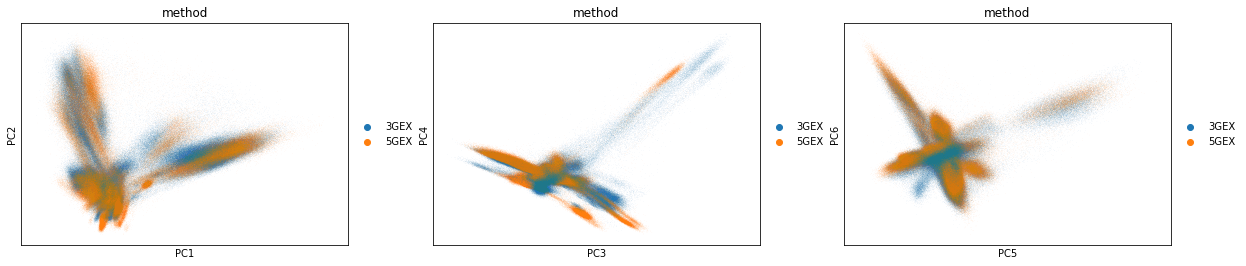

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


BBKNN runtime:  924.7678925991058
UMAP runtime:  3198.8243491649628


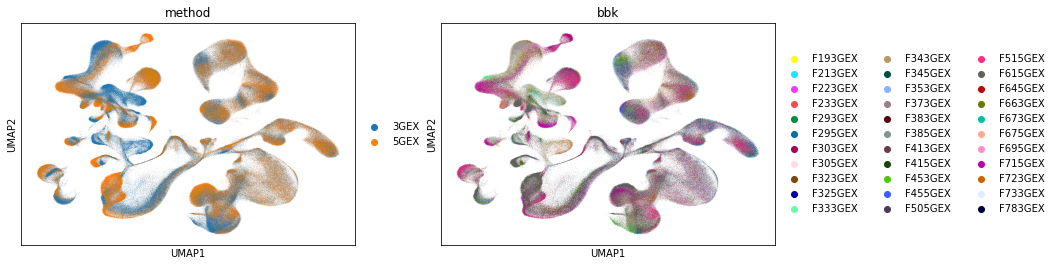

In [12]:
panfetal_utils.pfi_clustering(merged_pp, how="pbu", use_highly_variable=False)

In [48]:
# ## Full dataset
# start=datetime.now()
# bbknn(merged_pp, batch_key = "bbk", n_pcs=30, approx=True)
# bbknn_time = datetime.now()-start
# print("BBKNN runtime: ", str(bbknn_time))

# start=datetime.now()
# sc.tl.umap(merged_pp)
# umap_time = datetime.now()-start
# print("UMAP runtime: ", str(umap_time))

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:289: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/bbknn/__init__.py:290: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


BBKNN runtime:  0:15:22.474364
UMAP runtime:  0:45:44.819092


In [13]:
today = datetime.now().date().strftime('%Y%m%d')
merged_pp.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_{}.h5ad'.format(today))

In [78]:
# ## Here I am adding the labels post-hoc (waiting for full annotations) ##
merged_pp.obs = new_obs.loc[merged_pp.obs_names]

### Visualize results

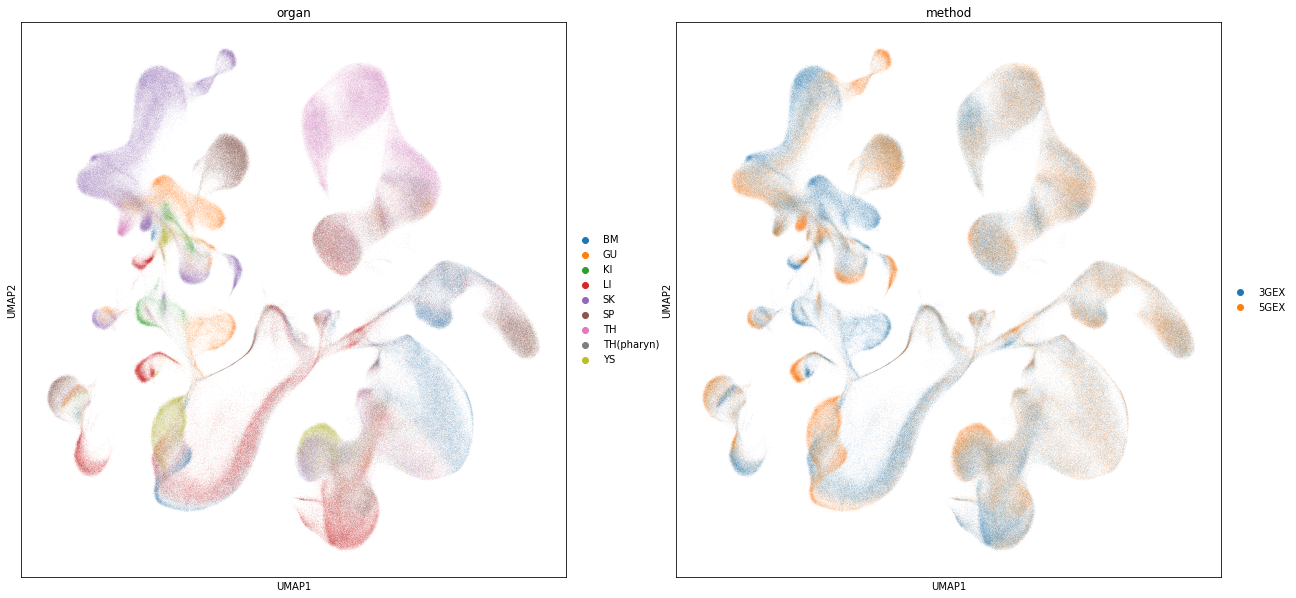

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=["organ", "method"])

... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'method' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical


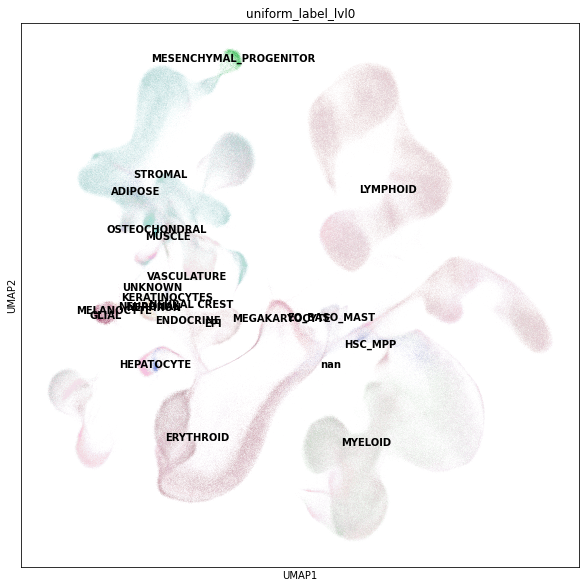

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=["uniform_label_lvl0"], legend_loc="on data")

Trying to set attribute `.uns` of view, copying.


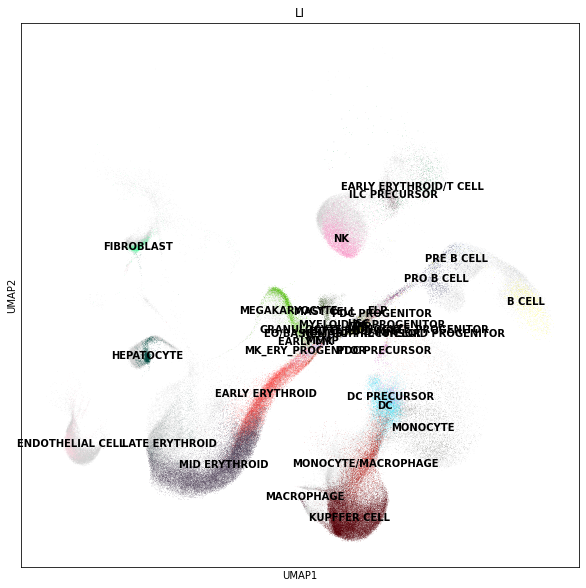

Trying to set attribute `.uns` of view, copying.


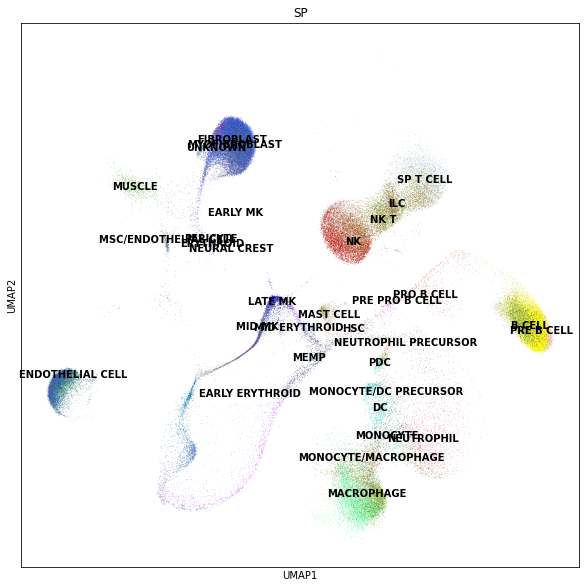

Trying to set attribute `.uns` of view, copying.


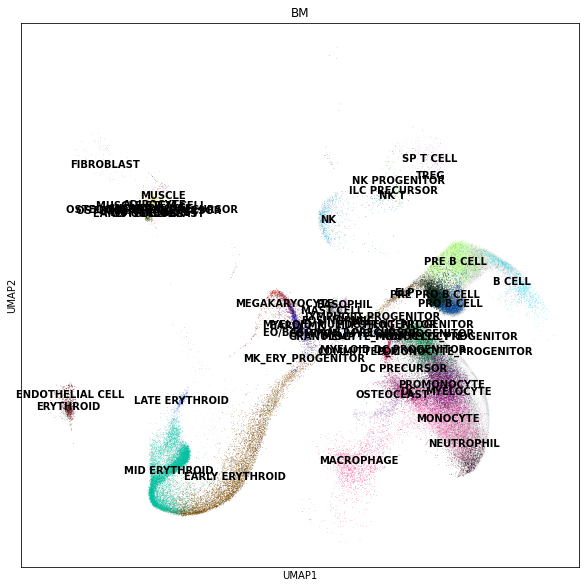

Trying to set attribute `.uns` of view, copying.


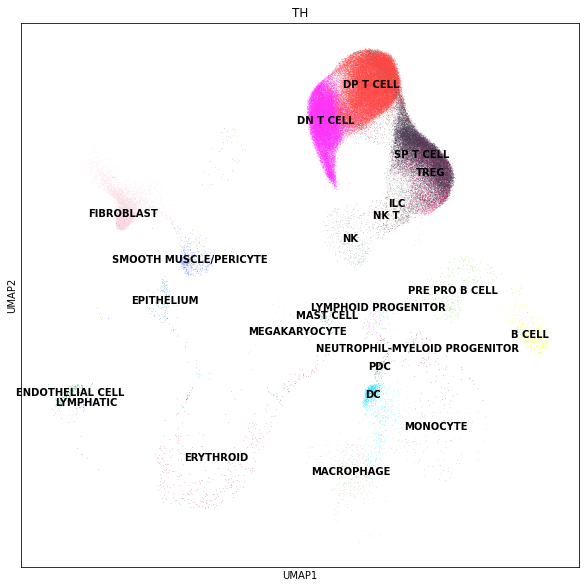

Trying to set attribute `.uns` of view, copying.


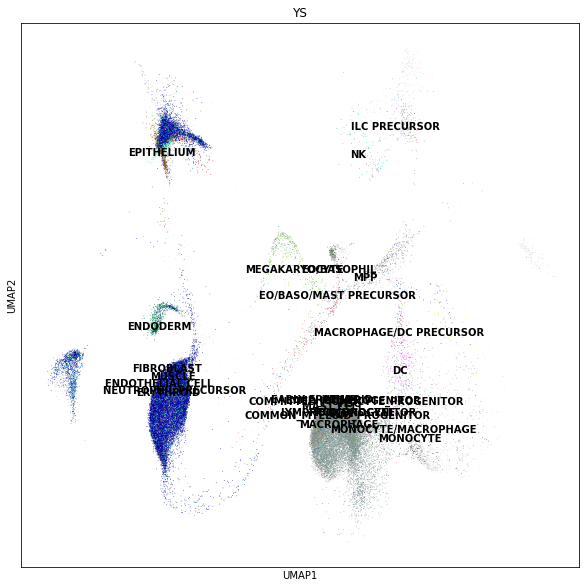

Trying to set attribute `.uns` of view, copying.


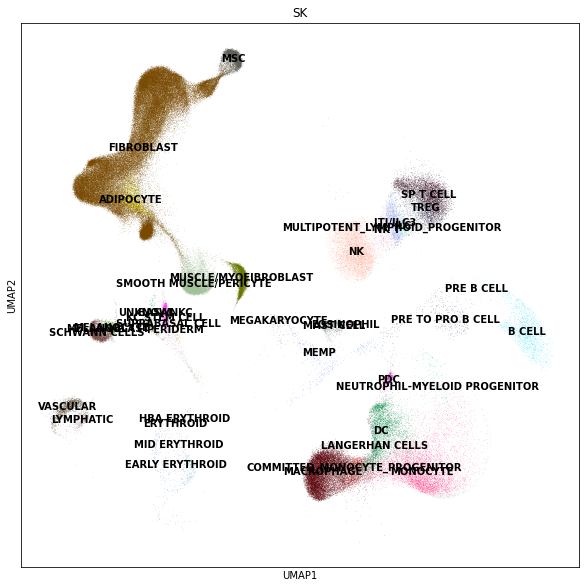

Trying to set attribute `.uns` of view, copying.


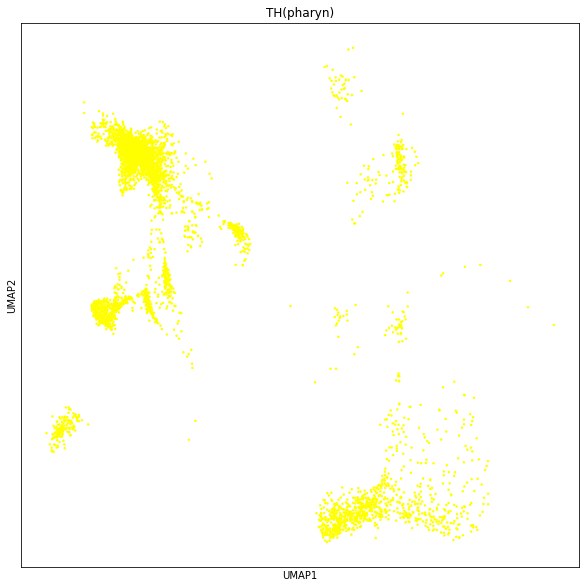

Trying to set attribute `.uns` of view, copying.


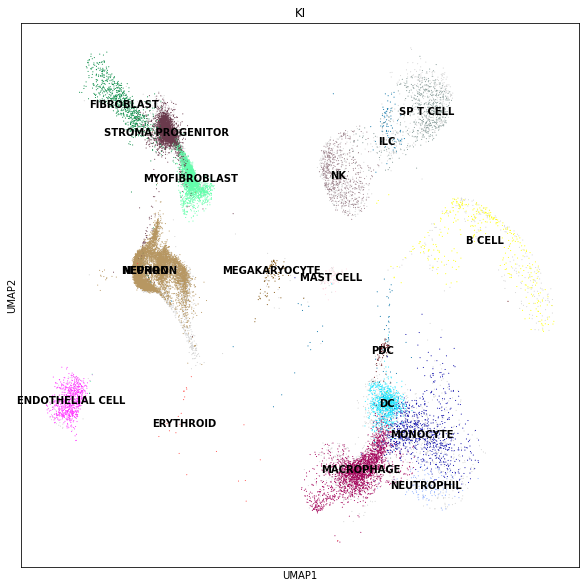

Trying to set attribute `.uns` of view, copying.


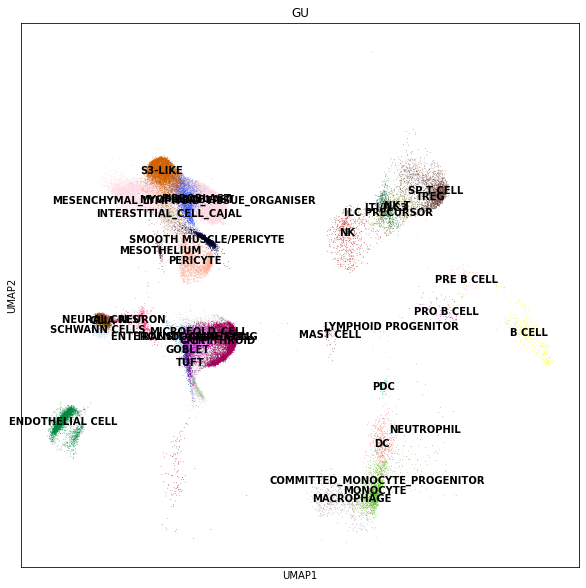

In [23]:
i=1
for org in merged_pp.obs['organ'].unique():
    subset_organ_adata = merged_pp[merged_pp.obs['organ']==org]
    sc.pl.umap(subset_organ_adata, color="uniform_label_expanded_merged", palette=sc.plotting.palettes.default_102,
               legend_loc="on data",
               groups=subset_organ_adata[subset_organ_adata.obs["uniform_label_expanded_merged"] != "nan"].obs["uniform_label_expanded_merged"].unique(),
               title=org
              )
    i += 1

Plot by broad cell types

Trying to set attribute `.uns` of view, copying.


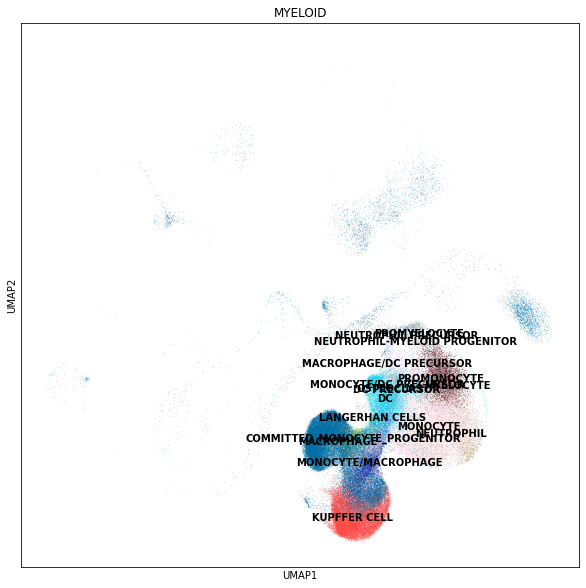

Trying to set attribute `.uns` of view, copying.


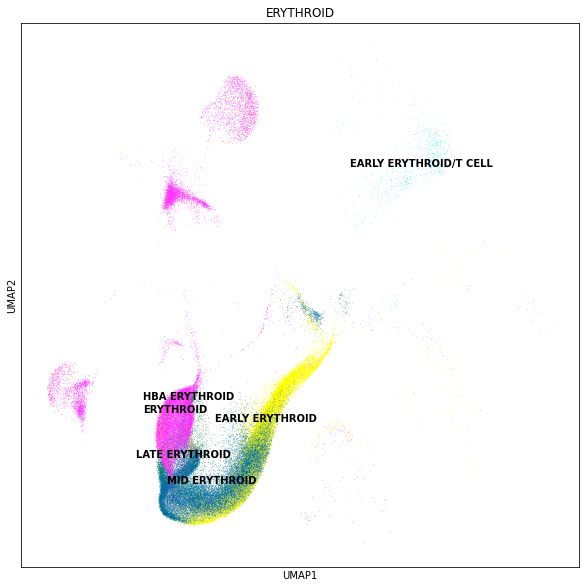

Trying to set attribute `.uns` of view, copying.


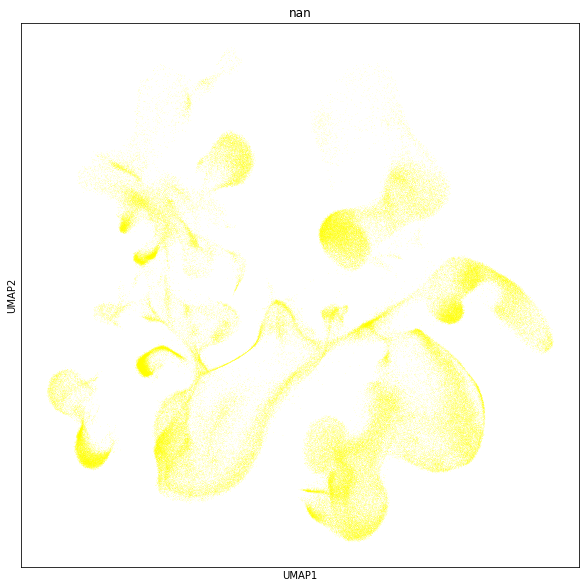

Trying to set attribute `.uns` of view, copying.


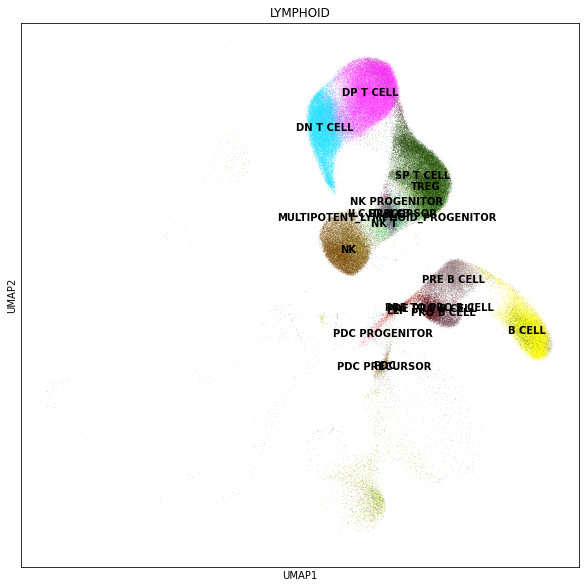

Trying to set attribute `.uns` of view, copying.


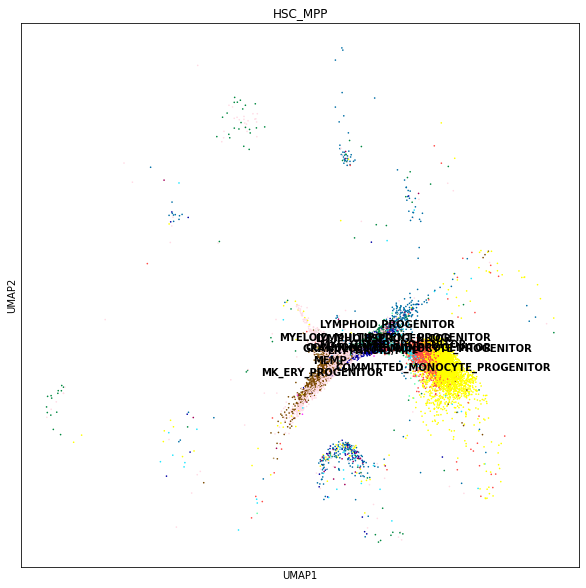

Trying to set attribute `.uns` of view, copying.


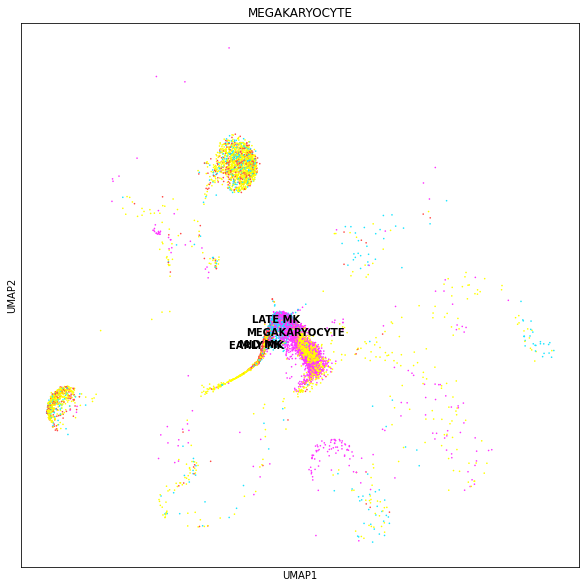

Trying to set attribute `.uns` of view, copying.


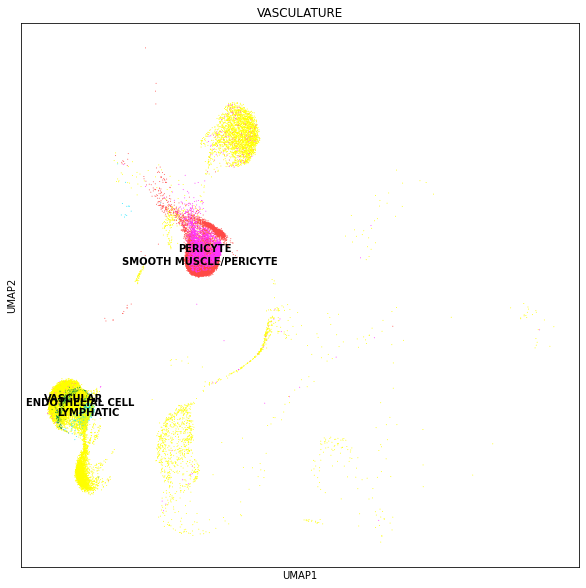

Trying to set attribute `.uns` of view, copying.


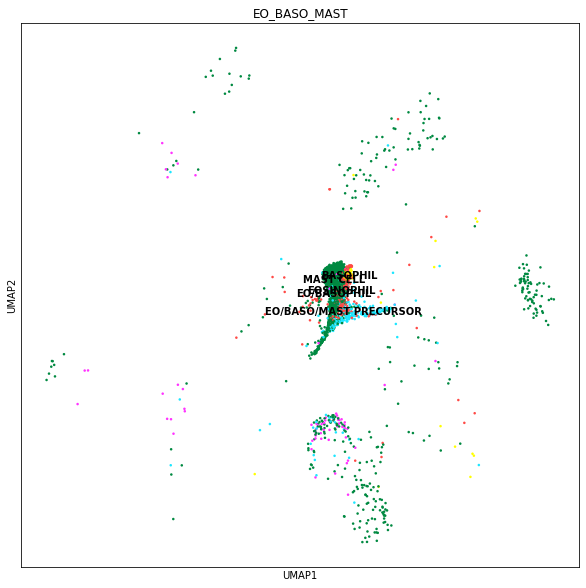

Trying to set attribute `.uns` of view, copying.


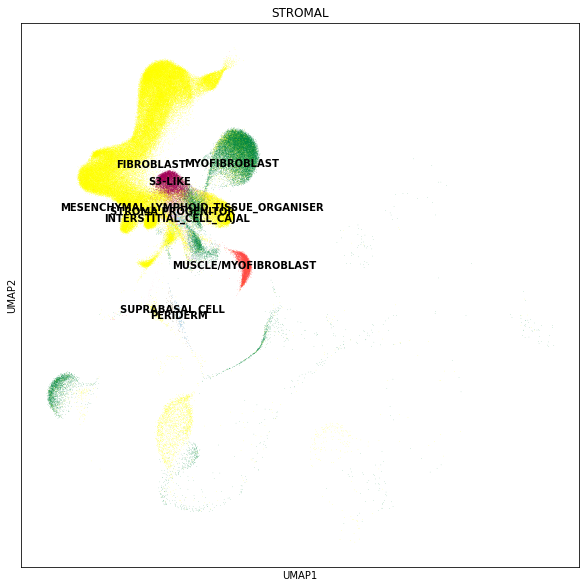

Trying to set attribute `.uns` of view, copying.


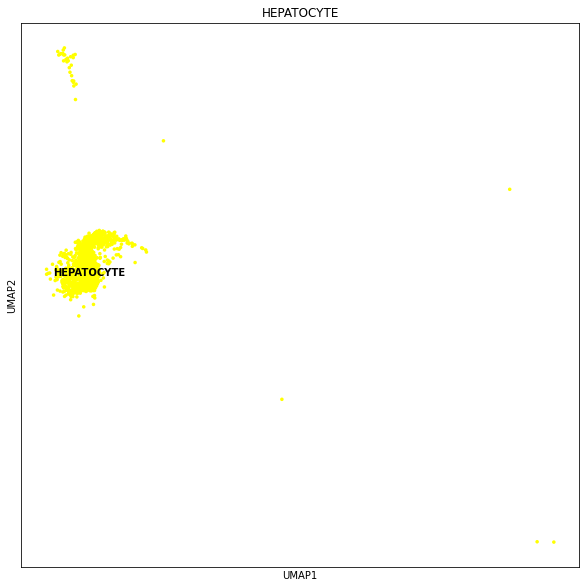

Trying to set attribute `.uns` of view, copying.


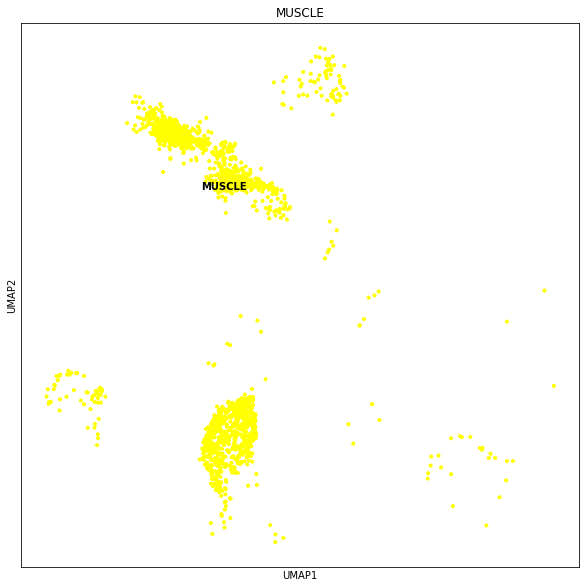

Trying to set attribute `.uns` of view, copying.


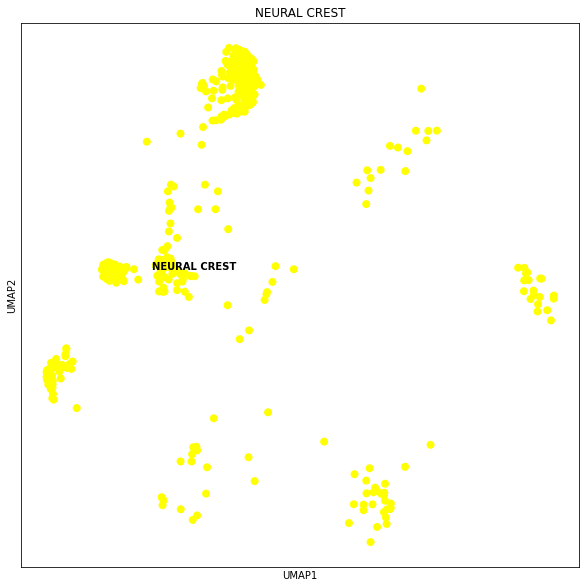

Trying to set attribute `.uns` of view, copying.


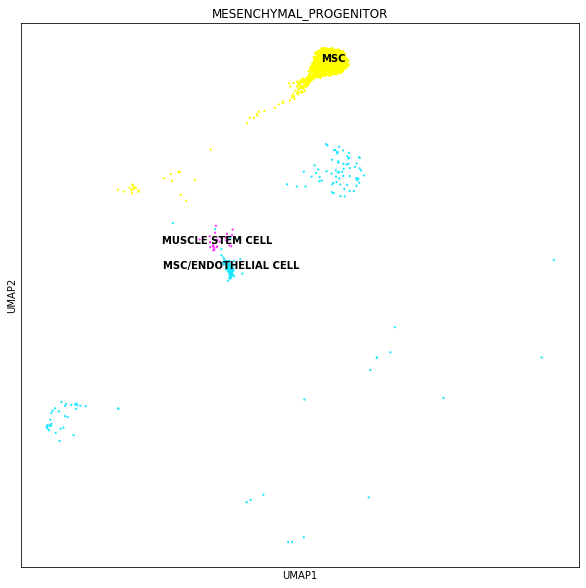

Trying to set attribute `.uns` of view, copying.


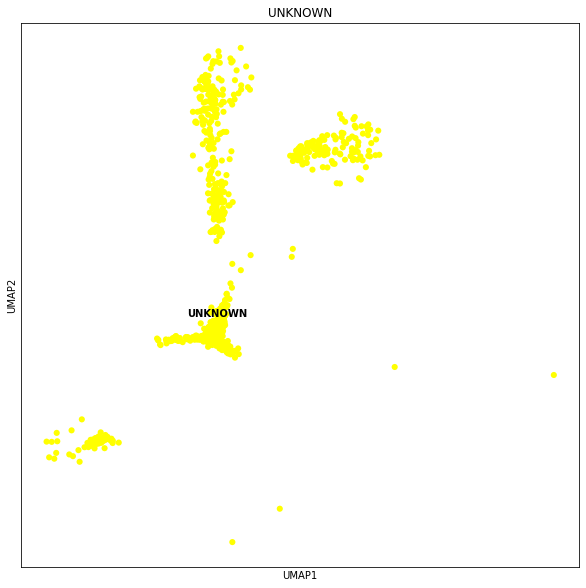

Trying to set attribute `.uns` of view, copying.


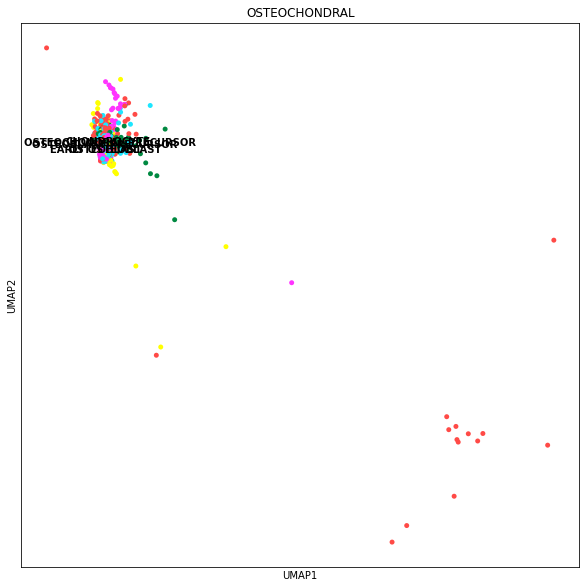

Trying to set attribute `.uns` of view, copying.


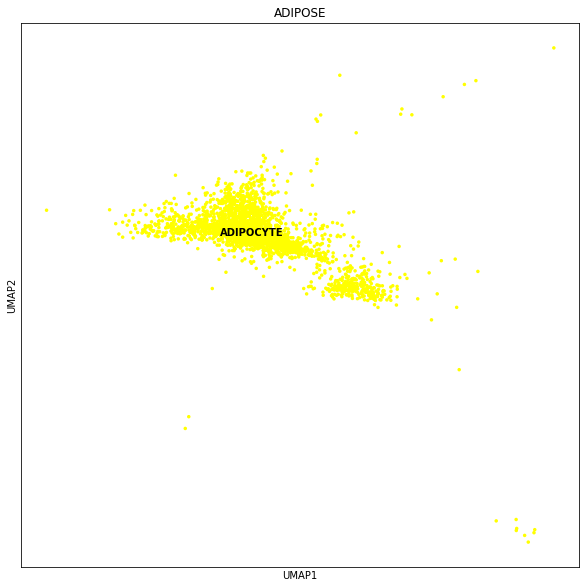

Trying to set attribute `.uns` of view, copying.


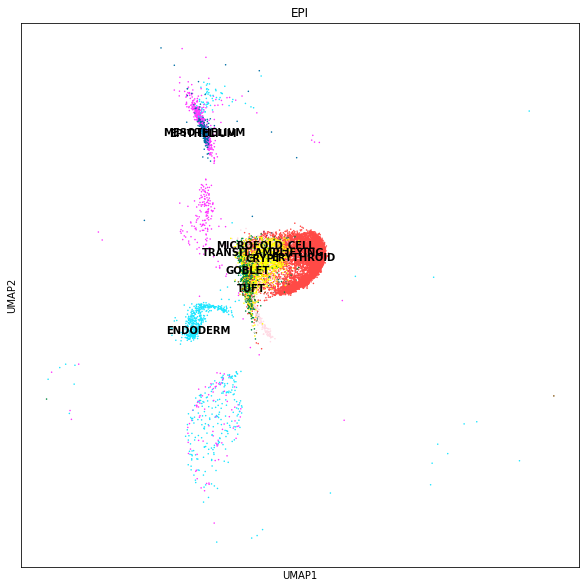

Trying to set attribute `.uns` of view, copying.


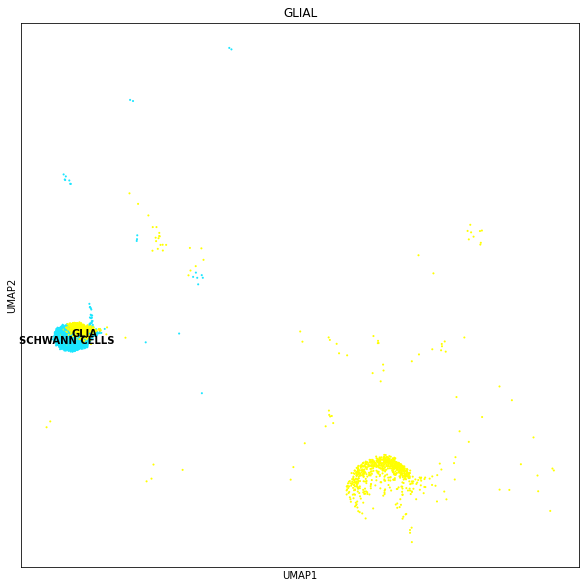

Trying to set attribute `.uns` of view, copying.


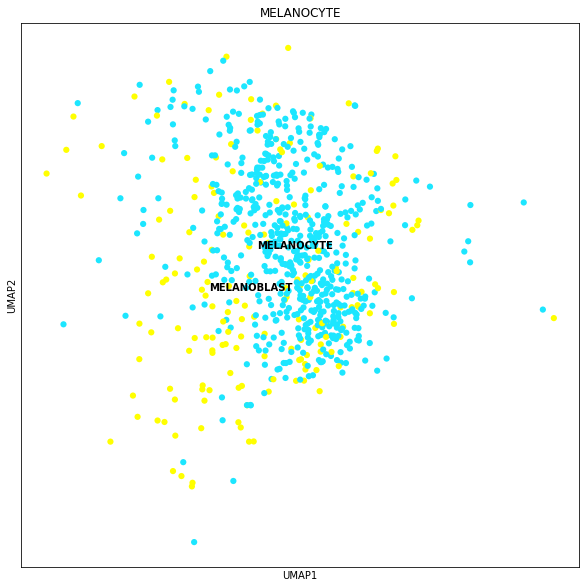

Trying to set attribute `.uns` of view, copying.


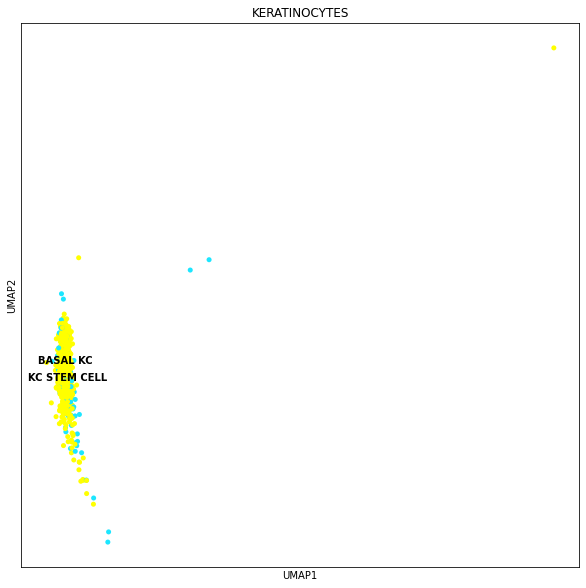

Trying to set attribute `.uns` of view, copying.


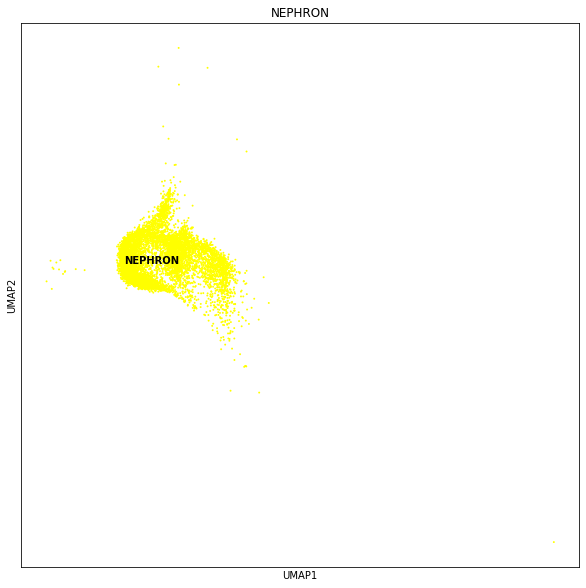

Trying to set attribute `.uns` of view, copying.


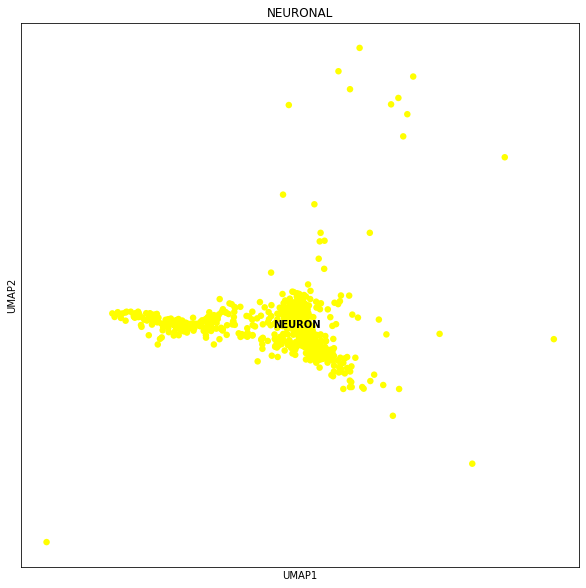

Trying to set attribute `.uns` of view, copying.


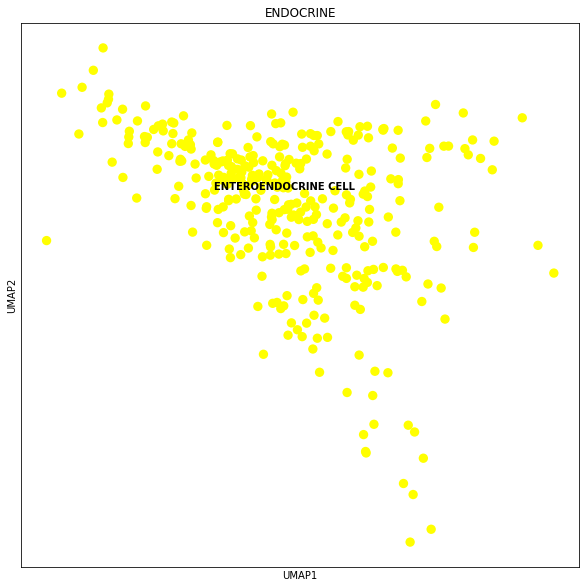

In [24]:
i=1
for lab in merged_pp.obs['uniform_label_lvl0'].unique():
    subset_organ_adata = merged_pp[merged_pp.obs['uniform_label_lvl0']==lab]
    sc.pl.umap(subset_organ_adata, color="uniform_label_expanded_merged", palette=sc.plotting.palettes.default_102,
               legend_loc="on data",
               groups=subset_organ_adata[subset_organ_adata.obs["uniform_label_expanded_merged"] != "nan"].obs["uniform_label_expanded_merged"].unique(),
               title=lab
              )
    i += 1

### Doublet removal

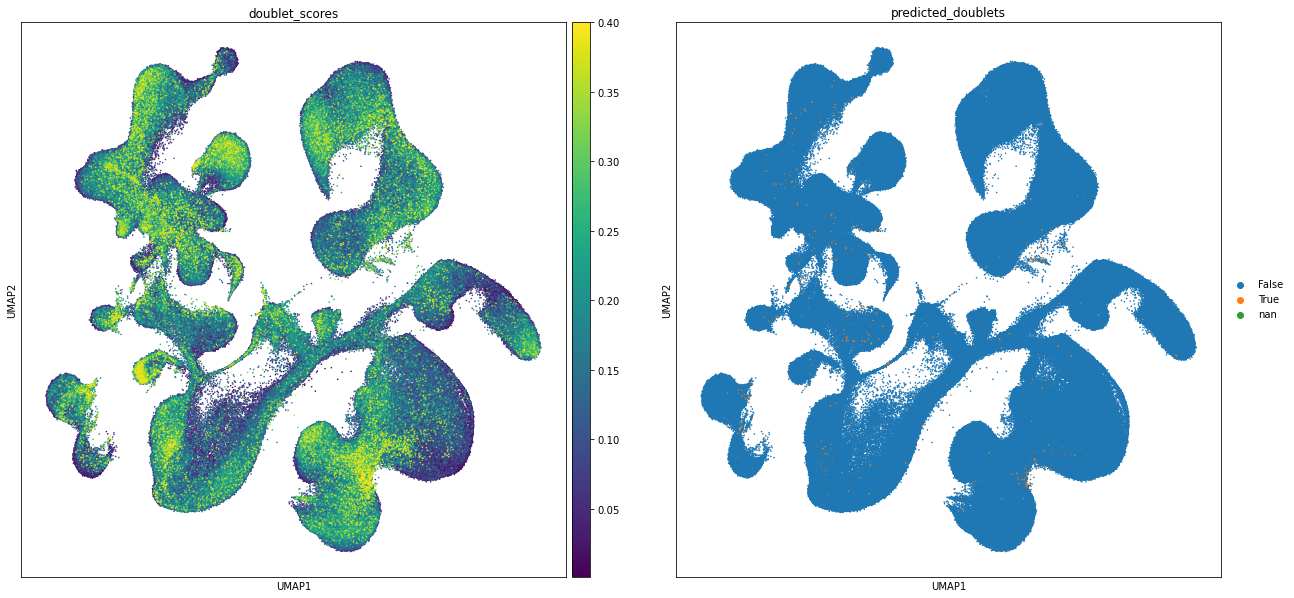

In [16]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_pp, color=['doublet_scores',"predicted_doublets"], size=10)

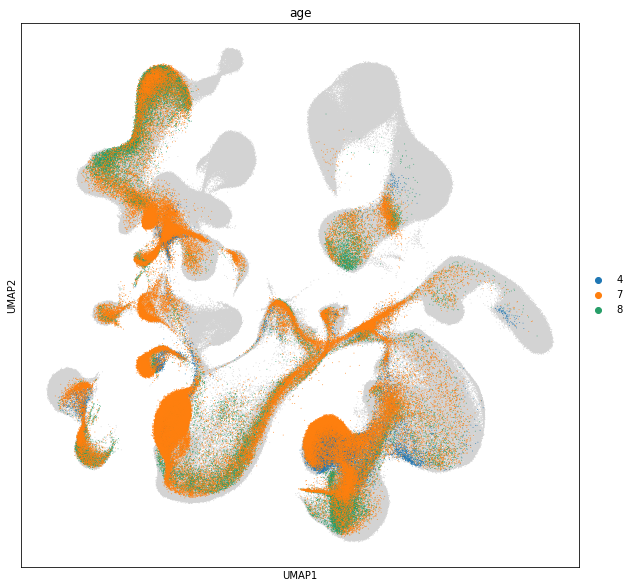

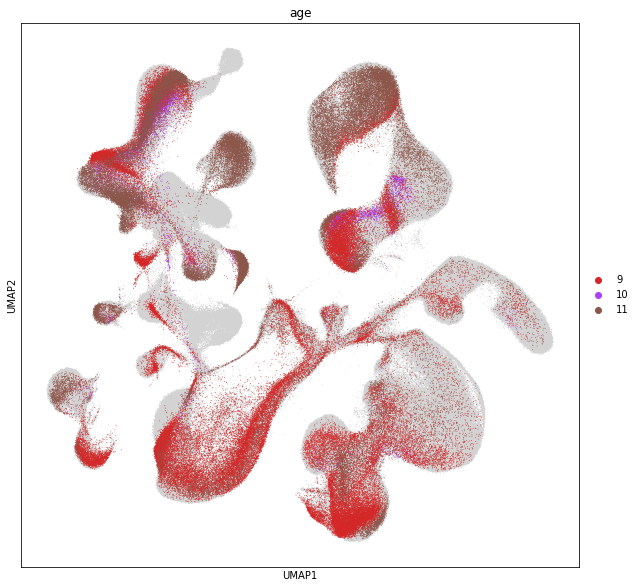

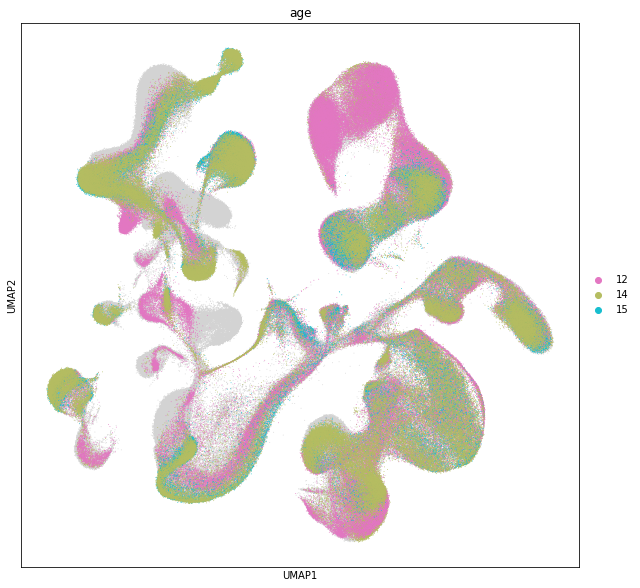

In [35]:
sc.pl.umap(merged_pp, color="age", groups=[4,7,8]  , size=3)
sc.pl.umap(merged_pp, color="age", groups=[9,10,11], size=3)
sc.pl.umap(merged_pp, color="age", groups=[12,14,15], size=3)

---